In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (



Dataframe Summary:
 store_lead_time  store_underage_cost Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %
               1                    4      Echelon Stock         NaN       NaN      6.892       0.000
               1                    4                GNN       6.904     6.890      6.900       0.112
               1                    4         Vanilla NN         NaN       NaN      6.910       0.260
               1                    4 decentralized_edge       7.607     7.594      7.610      10.418
               1                    9      Echelon Stock         NaN       NaN      8.360       0.000
               1                    9                GNN       8.373     8.353      8.368       0.092
               1                    9         Vanilla NN         NaN       NaN      8.380       0.240
               1                    9 decentralized_edge       9.149     9.125      9.152       9.474
               1                   19      Echelon Stock      

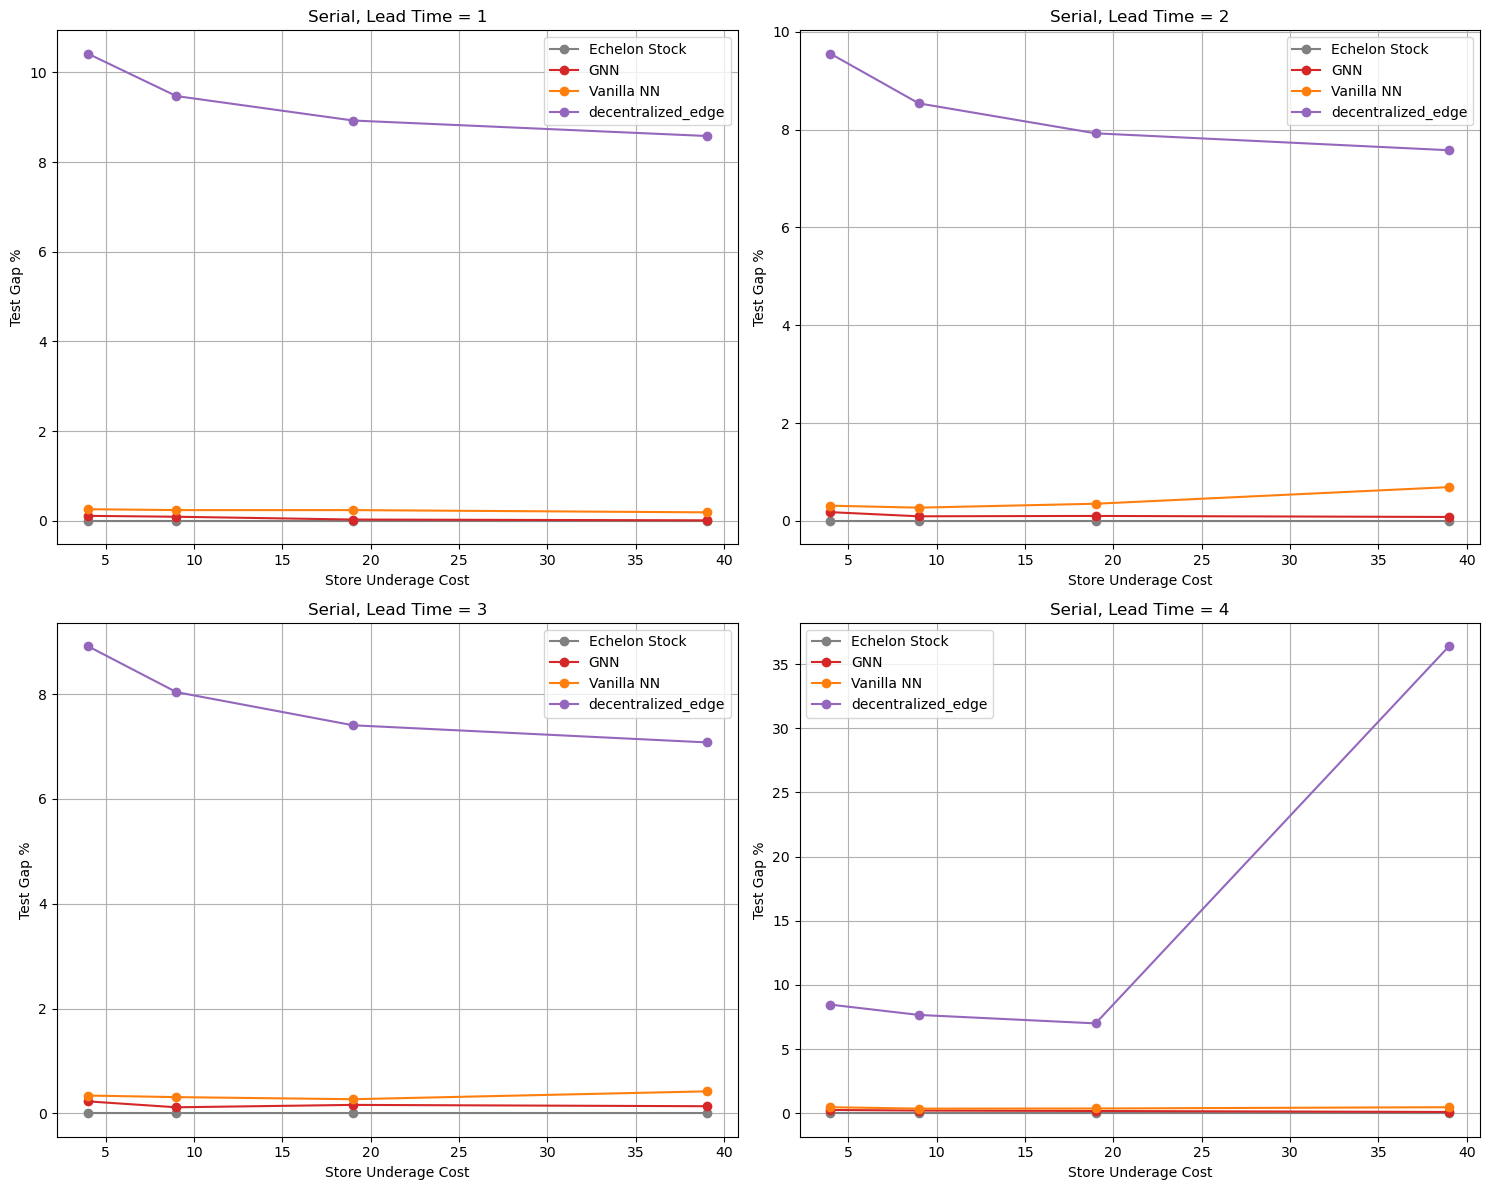

In [9]:
# Create vanilla results dataframe from the provided data
vanilla_data = []
for lead_time in [1, 2, 3, 4]:
    for underage_cost in [4, 9, 19, 39]:
        # Find matching row in provided data
        row = {
            'store_lead_time': lead_time,
            'store_underage_cost': underage_cost,
            'Architecture Class': 'Vanilla NN',
            'Test Loss': None
        }
        # Match with provided data and set test loss
        if lead_time == 1 and underage_cost == 4:
            row['Test Loss'] = 6.91
        elif lead_time == 1 and underage_cost == 9:
            row['Test Loss'] = 8.38
        elif lead_time == 1 and underage_cost == 19:
            row['Test Loss'] = 9.63
        elif lead_time == 1 and underage_cost == 39:
            row['Test Loss'] = 10.72
        elif lead_time == 2 and underage_cost == 4:
            row['Test Loss'] = 7.61
        elif lead_time == 2 and underage_cost == 9:
            row['Test Loss'] = 9.28
        elif lead_time == 2 and underage_cost == 19:
            row['Test Loss'] = 10.70
        elif lead_time == 2 and underage_cost == 39:
            row['Test Loss'] = 11.99
        elif lead_time == 3 and underage_cost == 4:
            row['Test Loss'] = 8.22
        elif lead_time == 3 and underage_cost == 9:
            row['Test Loss'] = 10.06
        elif lead_time == 3 and underage_cost == 19:
            row['Test Loss'] = 11.61
        elif lead_time == 3 and underage_cost == 39:
            row['Test Loss'] = 13.01
        elif lead_time == 4 and underage_cost == 4:
            row['Test Loss'] = 8.78
        elif lead_time == 4 and underage_cost == 9:
            row['Test Loss'] = 10.76
        elif lead_time == 4 and underage_cost == 19:
            row['Test Loss'] = 12.45
        elif lead_time == 4 and underage_cost == 39:
            row['Test Loss'] = 13.97
        vanilla_data.append(row)

# Create echelon stock results dataframe by removing test gap %
echelon_data = []
for lead_time in [1, 2, 3, 4]:
    for underage_cost in [4, 9, 19, 39]:
        row = {
            'store_lead_time': lead_time,
            'store_underage_cost': underage_cost,
            'Architecture Class': 'Echelon Stock',
            'Test Loss': None
        }
        if lead_time == 1 and underage_cost == 4:
            row['Test Loss'] = 6.91 / (1 + 0.0026)
        elif lead_time == 1 and underage_cost == 9:
            row['Test Loss'] = 8.38 / (1 + 0.0024)
        elif lead_time == 1 and underage_cost == 19:
            row['Test Loss'] = 9.63 / (1 + 0.0024)
        elif lead_time == 1 and underage_cost == 39:
            row['Test Loss'] = 10.72 / (1 + 0.0019)
        elif lead_time == 2 and underage_cost == 4:
            row['Test Loss'] = 7.61 / (1 + 0.0031)
        elif lead_time == 2 and underage_cost == 9:
            row['Test Loss'] = 9.28 / (1 + 0.0027)
        elif lead_time == 2 and underage_cost == 19:
            row['Test Loss'] = 10.70 / (1 + 0.0035)
        elif lead_time == 2 and underage_cost == 39:
            row['Test Loss'] = 11.99 / (1 + 0.0069)
        elif lead_time == 3 and underage_cost == 4:
            row['Test Loss'] = 8.22 / (1 + 0.0034)
        elif lead_time == 3 and underage_cost == 9:
            row['Test Loss'] = 10.06 / (1 + 0.0031)
        elif lead_time == 3 and underage_cost == 19:
            row['Test Loss'] = 11.61 / (1 + 0.0027)
        elif lead_time == 3 and underage_cost == 39:
            row['Test Loss'] = 13.01 / (1 + 0.0042)
        elif lead_time == 4 and underage_cost == 4:
            row['Test Loss'] = 8.78 / (1 + 0.0048)
        elif lead_time == 4 and underage_cost == 9:
            row['Test Loss'] = 10.76 / (1 + 0.0037)
        elif lead_time == 4 and underage_cost == 19:
            row['Test Loss'] = 12.45 / (1 + 0.0038)
        elif lead_time == 4 and underage_cost == 39:
            row['Test Loss'] = 13.97 / (1 + 0.0048)
        echelon_data.append(row)
echelon_df = pd.DataFrame(echelon_data)

vanilla_df = pd.DataFrame(vanilla_data)
dfs = [vanilla_df, echelon_df]

# Define color scheme for architecture types
color_scheme = {
    "GNN_MP": "#2ca02c", # Green
    "GNN": "#d62728", # red
    "Vanilla NN": "#ff7f0e",  # Orange
    "Echelon Stock": "#808080",  # Gray
    "decentralized_edge": "#9467bd",  # Purple
    "decentralized_edge_individual_nn": "#8B4513"  # Brown
}

linestyle_scheme = {
    "GNN_MP": "-", # Solid
    "GNN": "-", # Solid
    "Vanilla NN": "-",  # Solid 
    "Echelon Stock": "-",  # Solid
    "decentralized_edge": "-",  # Solid
    "decentralized_edge_individual_nn": "-"  # Solid
}

testset_name = "generic_architecture_serial"

# Define paths for each architecture
architectures = {
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN',
    # "GNN_MP": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP',
    "decentralized_edge": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/decentralized_edge',
    # "decentralized_edge_individual_nn": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/decentralized_edge_individual_nn'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
params = {
    'store_lead_time': [1, 2, 3, 4],
    'store_underage_cost': [4, 9, 19, 39]
}

for arch_name, path in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            df = results_interpretor.make_table({1: path},
                {'store_lead_time': lead_time,
                 'store_underage_cost': underage_cost,
                 'train_n_samples': [32768]},
                default_condition_setter, custom_data_filler, 
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['store_lead_time'] = lead_time
            df['store_underage_cost'] = underage_cost
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate test gap percentage
min_test_loss = df.groupby(['store_lead_time', 'store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100

print("\nDataframe Summary:")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide displays
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format floats to 3 decimal places

# Sort and select columns
columns = ['store_lead_time', 'store_underage_cost', 'Architecture Class',
          'Train Loss', 'Dev Loss', 'Test Loss', 'Test Gap %']
df_sorted = df.loc[df.groupby(['store_lead_time', 'store_underage_cost', 'Architecture Class'])['Test Loss'].idxmin()]
print(df_sorted[columns].to_string(index=False))

df = df_sorted

# Create 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
axes = [ax1, ax2, ax3, ax4]

# Plot for each lead time
for idx, lead_time in enumerate(params['store_lead_time']):
    lead_time_df = df[df['store_lead_time'] == lead_time]
    
    for arch in df['Architecture Class'].unique():
        arch_data = lead_time_df[lead_time_df['Architecture Class'] == arch]
        x = arch_data['store_underage_cost'].values
        y = arch_data['Test Gap %'].values
        # Sort x and y based on x values
        sort_idx = np.argsort(x)
        x = x[sort_idx]
        y = y[sort_idx]
        
        axes[idx].plot(x, y,
                      marker='o', 
                      label=arch,
                      color=color_scheme[arch],
                      linestyle=linestyle_scheme[arch])
    
    axes[idx].set_title(f'Serial, Lead Time = {lead_time}')
    axes[idx].set_xlabel('Store Underage Cost')
    axes[idx].set_ylabel('Test Gap %')
    axes[idx].grid(True)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [13]:
for i in range(len(dfs)):
    print(dfs[i].to_string())

    store_lead_time  store_underage_cost Architecture Class  Test Loss
0                 1                    4         Vanilla NN      6.910
1                 1                    9         Vanilla NN      8.380
2                 1                   19         Vanilla NN      9.630
3                 1                   39         Vanilla NN     10.720
4                 2                    4         Vanilla NN      7.610
5                 2                    9         Vanilla NN      9.280
6                 2                   19         Vanilla NN     10.700
7                 2                   39         Vanilla NN     11.990
8                 3                    4         Vanilla NN      8.220
9                 3                    9         Vanilla NN     10.060
10                3                   19         Vanilla NN     11.610
11                3                   39         Vanilla NN     13.010
12                4                    4         Vanilla NN      8.780
13    

In [7]:
# Calculate average % difference between GNN_MP and other architectures
gnn_data = df[df['Architecture Class'] == 'GNN']
vanilla_data = df[df['Architecture Class'] == 'Vanilla NN']
echelon_data = df[df['Architecture Class'] == 'Echelon Stock']

# Merge GNN with Vanilla NN data
vanilla_comparison = pd.merge(
    gnn_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    vanilla_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost'],
    suffixes=('_gnn', '_vanilla')
)

# Merge GNN with Echelon Stock data
echelon_comparison = pd.merge(
    gnn_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    echelon_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost'],
    suffixes=('_gnn', '_echelon')
)

# Calculate % difference for each pair
vanilla_comparison['pct_diff'] = ((vanilla_comparison['Test Loss_gnn'] - vanilla_comparison['Test Loss_vanilla']) / vanilla_comparison['Test Loss_vanilla']) * 100
echelon_comparison['pct_diff'] = ((echelon_comparison['Test Loss_gnn'] - echelon_comparison['Test Loss_echelon']) / echelon_comparison['Test Loss_echelon']) * 100

# Calculate and display average % differences
avg_pct_diff_vanilla = vanilla_comparison['pct_diff'].mean()
avg_pct_diff_echelon = echelon_comparison['pct_diff'].mean()
print(f"Average % difference between GNN and Vanilla NN test losses: {avg_pct_diff_vanilla:.2f}%")
print(f"Average % difference between GNN and Echelon Stock test losses: {avg_pct_diff_echelon:.2f}%")

Average % difference between GNN and Vanilla NN test losses: -0.22%
Average % difference between GNN and Echelon Stock test losses: 0.13%



Dataframe Summary:
 store_lead_time  store_underage_cost Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %
               1                    4      Echelon Stock         NaN       NaN      6.892       0.000
               1                    9      Echelon Stock         NaN       NaN      8.360       0.000
               1                   19      Echelon Stock         NaN       NaN      9.607       0.000
               1                   39      Echelon Stock         NaN       NaN     10.700       0.000
               2                    4      Echelon Stock         NaN       NaN      7.586       0.000
               2                    9      Echelon Stock         NaN       NaN      9.255       0.000
               2                   19      Echelon Stock         NaN       NaN     10.663       0.000
               2                   39      Echelon Stock         NaN       NaN     11.908       0.000
               3                    4      Echelon Stock      

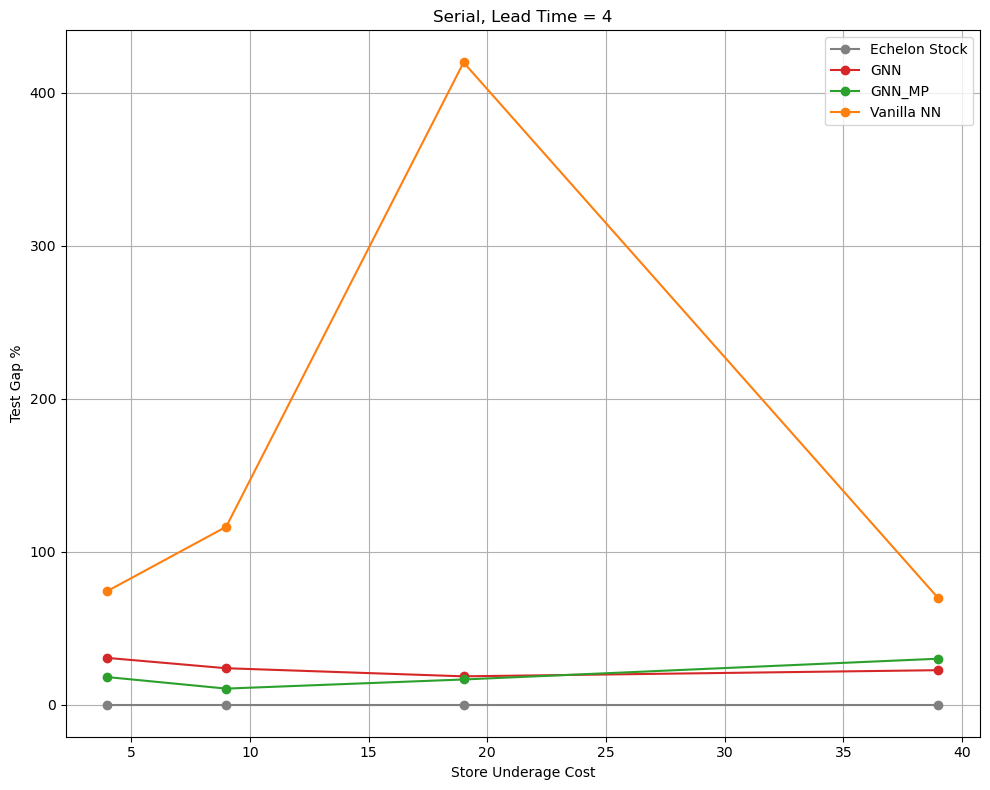

In [3]:
# Create vanilla results dataframe from the provided data
vanilla_data = []
for lead_time in [1, 2, 3, 4]:
    for underage_cost in [4, 9, 19, 39]:
        # Find matching row in provided data
        row = {
            'store_lead_time': lead_time,
            'store_underage_cost': underage_cost,
            'Architecture Class': 'Vanilla NN',
            'Test Loss': None
        }
        # Match with provided data and set test loss
        if lead_time == 1 and underage_cost == 4:
            row['Test Loss'] = 6.91
        elif lead_time == 1 and underage_cost == 9:
            row['Test Loss'] = 8.38
        elif lead_time == 1 and underage_cost == 19:
            row['Test Loss'] = 9.63
        elif lead_time == 1 and underage_cost == 39:
            row['Test Loss'] = 10.72
        elif lead_time == 2 and underage_cost == 4:
            row['Test Loss'] = 7.61
        elif lead_time == 2 and underage_cost == 9:
            row['Test Loss'] = 9.28
        elif lead_time == 2 and underage_cost == 19:
            row['Test Loss'] = 10.70
        elif lead_time == 2 and underage_cost == 39:
            row['Test Loss'] = 11.99
        elif lead_time == 3 and underage_cost == 4:
            row['Test Loss'] = 8.22
        elif lead_time == 3 and underage_cost == 9:
            row['Test Loss'] = 10.06
        elif lead_time == 3 and underage_cost == 19:
            row['Test Loss'] = 11.61
        elif lead_time == 3 and underage_cost == 39:
            row['Test Loss'] = 13.01
        elif lead_time == 4 and underage_cost == 4:
            row['Test Loss'] = 8.78
        elif lead_time == 4 and underage_cost == 9:
            row['Test Loss'] = 10.76
        elif lead_time == 4 and underage_cost == 19:
            row['Test Loss'] = 12.45
        elif lead_time == 4 and underage_cost == 39:
            row['Test Loss'] = 13.97
        vanilla_data.append(row)

# Create echelon stock results dataframe by removing test gap %
echelon_data = []
for lead_time in [1, 2, 3, 4]:
    for underage_cost in [4, 9, 19, 39]:
        row = {
            'store_lead_time': lead_time,
            'store_underage_cost': underage_cost,
            'Architecture Class': 'Echelon Stock',
            'Test Loss': None
        }
        if lead_time == 1 and underage_cost == 4:
            row['Test Loss'] = 6.91 / (1 + 0.0026)
        elif lead_time == 1 and underage_cost == 9:
            row['Test Loss'] = 8.38 / (1 + 0.0024)
        elif lead_time == 1 and underage_cost == 19:
            row['Test Loss'] = 9.63 / (1 + 0.0024)
        elif lead_time == 1 and underage_cost == 39:
            row['Test Loss'] = 10.72 / (1 + 0.0019)
        elif lead_time == 2 and underage_cost == 4:
            row['Test Loss'] = 7.61 / (1 + 0.0031)
        elif lead_time == 2 and underage_cost == 9:
            row['Test Loss'] = 9.28 / (1 + 0.0027)
        elif lead_time == 2 and underage_cost == 19:
            row['Test Loss'] = 10.70 / (1 + 0.0035)
        elif lead_time == 2 and underage_cost == 39:
            row['Test Loss'] = 11.99 / (1 + 0.0069)
        elif lead_time == 3 and underage_cost == 4:
            row['Test Loss'] = 8.22 / (1 + 0.0034)
        elif lead_time == 3 and underage_cost == 9:
            row['Test Loss'] = 10.06 / (1 + 0.0031)
        elif lead_time == 3 and underage_cost == 19:
            row['Test Loss'] = 11.61 / (1 + 0.0027)
        elif lead_time == 3 and underage_cost == 39:
            row['Test Loss'] = 13.01 / (1 + 0.0042)
        elif lead_time == 4 and underage_cost == 4:
            row['Test Loss'] = 8.78 / (1 + 0.0048)
        elif lead_time == 4 and underage_cost == 9:
            row['Test Loss'] = 10.76 / (1 + 0.0037)
        elif lead_time == 4 and underage_cost == 19:
            row['Test Loss'] = 12.45 / (1 + 0.0038)
        elif lead_time == 4 and underage_cost == 39:
            row['Test Loss'] = 13.97 / (1 + 0.0048)
        echelon_data.append(row)
dfs = [pd.DataFrame(echelon_data)]
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#d62728", # red
    "GNN_MP": "#2ca02c", # Green
    "GNN_MP_varying_training_primitives": "#1f77b4", # Blue
    "GNN_MP_Large_varying_training_primitives": "#9467bd", # Purple
    "Vanilla NN": "#ff7f0e",  # Orange
    "Echelon Stock": "#808080",  # Gray
    "GNN_MP_varying_training_primitives_include_test_primitives": "#d62728",  # Red
    "GNN_MP_skip_connection_varying_training_primitives": "#17becf"  # Light blue
}

linestyle_scheme = {
    "GNN": "-", # Solid
    "GNN_MP": "-", # Solid
    "GNN_MP_varying_training_primitives": "-", # Solid
    "Vanilla NN": "-",  # Solid 
    "Echelon Stock": "-",  # Solid
    "GNN_MP_varying_training_primitives_include_test_primitives": "-",  # Solid
    "GNN_MP_skip_connection_varying_training_primitives": "-",  # Solid
    "GNN_MP_Large_varying_training_primitives": "-"  # Solid
}

testset_name = "generic_architecture_serial"

# Define paths for each architecture
architectures = {
    "GNN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN',
    "GNN_MP": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP',
    # "GNN_MP_varying_training_primitives": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_varying_training_primitives',
    "Vanilla NN": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial',
    # "GNN_MP_varying_training_primitives_include_test_primitives": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_varying_training_primitives_include_test_primitives',
    # "GNN_MP_skip_connection_varying_training_primitives": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_skip_connection_varying_training_primitives',
    # "GNN_MP_Large_varying_training_primitives": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_Large_varying_training_primitives'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
params = {
    'store_lead_time': [4],
    'store_underage_cost': [4, 9, 19, 39]
}

for arch_name, path in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            df = results_interpretor.make_table({1: path},
                {'store_lead_time': lead_time,
                 'store_underage_cost': underage_cost,
                 'train_n_samples': [16]},
                default_condition_setter, custom_data_filler, 
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['store_lead_time'] = lead_time
            df['store_underage_cost'] = underage_cost
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate test gap percentage
min_test_loss = df.groupby(['store_lead_time', 'store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100

print("\nDataframe Summary:")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide displays
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format floats to 3 decimal places

# Sort and select columns
columns = ['store_lead_time', 'store_underage_cost', 'Architecture Class',
          'Train Loss', 'Dev Loss', 'Test Loss', 'Test Gap %']
df_sorted = df.loc[df.groupby(['store_lead_time', 'store_underage_cost', 'Architecture Class'])['Test Loss'].idxmin()]
print(df_sorted[columns].to_string(index=False))

df = df_sorted

# Create single plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot for lead time 4
lead_time_df = df[df['store_lead_time'] == 4]

for arch in df['Architecture Class'].unique():
    arch_data = lead_time_df[lead_time_df['Architecture Class'] == arch]
    x = arch_data['store_underage_cost'].values
    y = arch_data['Test Gap %'].values
    # Sort x and y based on x values
    sort_idx = np.argsort(x)
    x = x[sort_idx]
    y = y[sort_idx]
    
    ax.plot(x, y,
            marker='o', 
            label=arch,
            color=color_scheme[arch],
            linestyle=linestyle_scheme[arch])

ax.set_title(f'Serial, Lead Time = 4')
ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Gap %')
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

In [9]:
# Calculate average % difference between GNN_MP and other architectures
vanilla_data = df[df['Architecture Class'] == 'Vanilla NN']
echelon_data = df[df['Architecture Class'] == 'Echelon Stock']
gnn_data = df[df['Architecture Class'] == 'GNN']

# Merge GNN_MP with Vanilla NN data
vanilla_comparison = pd.merge(
    gnn_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    vanilla_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost'],
    suffixes=('_gnn_mp', '_vanilla')
)

# Merge GNN_MP with Echelon Stock data
echelon_comparison = pd.merge(
    gnn_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    echelon_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost'],
    suffixes=('_gnn_mp', '_echelon')
)

# Calculate % difference for each pair
vanilla_comparison['pct_diff'] = ((vanilla_comparison['Test Loss_gnn_mp'] - vanilla_comparison['Test Loss_vanilla']) / vanilla_comparison['Test Loss_vanilla']) * 100
echelon_comparison['pct_diff'] = ((echelon_comparison['Test Loss_gnn_mp'] - echelon_comparison['Test Loss_echelon']) / echelon_comparison['Test Loss_echelon']) * 100

# Calculate and display average % differences
avg_pct_diff_vanilla = vanilla_comparison['pct_diff'].mean()
avg_pct_diff_echelon = echelon_comparison['pct_diff'].mean()
print(f"Average % difference between GNN_MP and Vanilla NN test losses: {avg_pct_diff_vanilla:.2f}%")
print(f"Average % difference between GNN_MP and Echelon Stock test losses: {avg_pct_diff_echelon:.2f}%")

Average % difference between GNN_MP and Vanilla NN test losses: -43.19%
Average % difference between GNN_MP and Echelon Stock test losses: 23.83%


In [14]:
# Calculate average % difference between GNN_MP and other architectures
gnn_mp_data = df[df['Architecture Class'] == 'GNN_MP']
vanilla_data = df[df['Architecture Class'] == 'Vanilla NN']
echelon_data = df[df['Architecture Class'] == 'Echelon Stock']
gnn_data = df[df['Architecture Class'] == 'GNN']

# Merge GNN_MP with Vanilla NN data
vanilla_comparison = pd.merge(
    gnn_mp_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    vanilla_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost'],
    suffixes=('_gnn_mp', '_vanilla')
)

# Merge GNN_MP with Echelon Stock data
echelon_comparison = pd.merge(
    gnn_mp_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    echelon_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost'],
    suffixes=('_gnn_mp', '_echelon')
)

# Merge GNN_MP with GNN data
gnn_comparison = pd.merge(
    gnn_mp_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    gnn_data[['store_lead_time', 'store_underage_cost', 'Test Loss']], 
    on=['store_lead_time', 'store_underage_cost'],
    suffixes=('_gnn_mp', '_gnn')
)

# Calculate % difference for each pair (how much other architectures are worse than GNN_MP)
vanilla_comparison['pct_diff'] = ((vanilla_comparison['Test Loss_vanilla'] - vanilla_comparison['Test Loss_gnn_mp']) / vanilla_comparison['Test Loss_gnn_mp']) * 100
echelon_comparison['pct_diff'] = ((echelon_comparison['Test Loss_echelon'] - echelon_comparison['Test Loss_gnn_mp']) / echelon_comparison['Test Loss_gnn_mp']) * 100
gnn_comparison['pct_diff'] = ((gnn_comparison['Test Loss_gnn'] - gnn_comparison['Test Loss_gnn_mp']) / gnn_comparison['Test Loss_gnn_mp']) * 100

# Calculate and display average % differences
avg_pct_diff_vanilla = vanilla_comparison['pct_diff'].mean()
avg_pct_diff_echelon = echelon_comparison['pct_diff'].mean()
avg_pct_diff_gnn = gnn_comparison['pct_diff'].mean()
print(f"Average % difference of Vanilla NN compared to GNN_MP test losses: {avg_pct_diff_vanilla:.2f}%")
print(f"Average % difference of Echelon Stock compared to GNN_MP test losses: {avg_pct_diff_echelon:.2f}%")
print(f"Average % difference of GNN compared to GNN_MP test losses: {avg_pct_diff_gnn:.2f}%")

Average % difference of Vanilla NN compared to GNN_MP test losses: 130.07%
Average % difference of Echelon Stock compared to GNN_MP test losses: -15.48%
Average % difference of GNN compared to GNN_MP test losses: 4.67%



Dataframe Summary:
 store_lead_time  store_underage_cost  Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %  Mean Test Loss  Test Loss Std
               2                    9              GNN_MP       9.351     9.286      9.307       0.117          14.652          9.024
               2                    9  echelon_stock_hard       9.278     9.287      9.296       0.000           9.297          0.001
               2                    9 vanilla_serial_hard       9.292     9.306      9.385       0.951           9.448          0.061


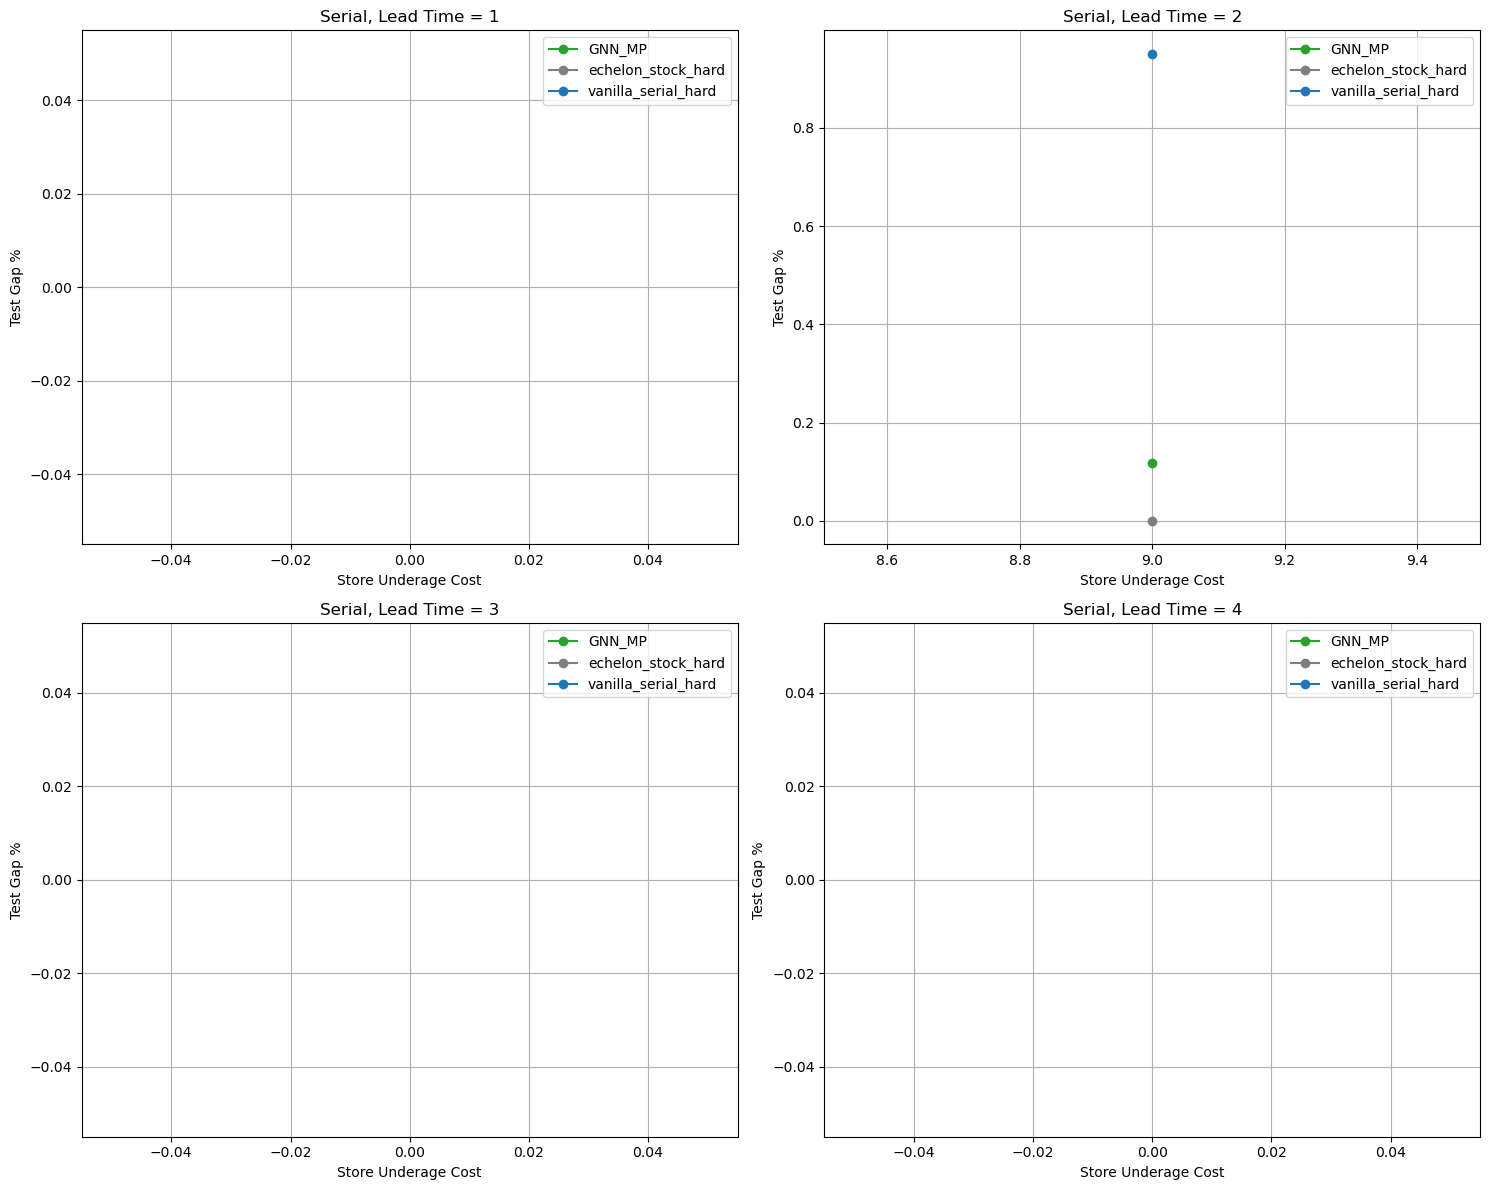

In [2]:
# Define color scheme for architecture types
color_scheme = {
    "echelon_stock_hard": "#7f7f7f",  # Purple
    "vanilla_serial_hard": "#1f77b4",  # Blue
    "GNN_MP": "#2ca02c",  # Green
    "GNN_MP_NN_per_layer": "#ff7f0e",  # Orange
    "GNN_MP_skip_connection": "#d62728",  # Red
    "GNN_MP_NN_per_layer_skip_connection": "#17becf",  # Cyan
}

linestyle_scheme = {
    "echelon_stock_hard": "-",  # Solid
    "vanilla_serial_hard": "-",  # Solid
    "GNN_MP": "-",  # Solid
    "GNN_MP_NN_per_layer": "-",  # Solid
    "GNN_MP_skip_connection": "-",  # Solid
    "GNN_MP_NN_per_layer_skip_connection": "-",  # Solid
}

testset_name = "generic_architecture_serial_hard"

# Define paths for each architecture
architectures = {
    "echelon_stock_hard": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/echelon_stock_hard',
    "vanilla_serial_hard": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial_hard',
    "GNN_MP": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP',
    # "GNN_MP_NN_per_layer": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_NN_per_layer',
    # "GNN_MP_skip_connection": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_skip_connection',
    # "GNN_MP_NN_per_layer_skip_connection": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP_NN_per_layer_skip_connection',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
dfs = []
params = {
    'store_lead_time': [1, 2, 3, 4],
    'store_underage_cost': [9]#[4, 9, 19, 39]
}

for arch_name, path in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            df = results_interpretor.make_table({1: path},
                {'store_lead_time': lead_time,
                 'store_underage_cost': underage_cost,
                 'train_n_samples': [32768],
                 'samples': [1,2,3]},
                default_condition_setter, custom_data_filler, 
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['store_lead_time'] = lead_time
            df['store_underage_cost'] = underage_cost
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate test gap percentage
min_test_loss = df.groupby(['store_lead_time', 'store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100


print("\nDataframe Summary:")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide displays
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format floats to 3 decimal places

# Sort and select columns
# Calculate mean and standard deviation of test loss grouped by lead time, underage cost and architecture class
variance_df = df.groupby(['store_lead_time', 'store_underage_cost', 'Architecture Class'])['Test Loss'].agg(['mean', 'std']).reset_index()
variance_df.columns = ['store_lead_time', 'store_underage_cost', 'Architecture Class', 'Mean Test Loss', 'Test Loss Std']

# Round std to 6 decimal places
variance_df['Test Loss Std'] = variance_df['Test Loss Std'].round(6)
variance_df['Mean Test Loss'] = variance_df['Mean Test Loss'].round(6)

# Merge mean and std back into main dataframe
df_sorted = df.merge(
    variance_df, 
    on=['store_lead_time', 'store_underage_cost', 'Architecture Class'],
    how='left'
).sort_values(['store_lead_time', 'store_underage_cost'])

columns = ['store_lead_time', 'store_underage_cost', 'Architecture Class',
          'Train Loss', 'Dev Loss', 'Test Loss', 'Test Gap %', 
          'Mean Test Loss', 'Test Loss Std']
df_sorted = df_sorted.loc[df_sorted.groupby(['store_lead_time', 'store_underage_cost', 'Architecture Class'])['Test Loss'].idxmin()]
print(df_sorted[columns].to_string(index=False))

df = df_sorted

# Create 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
axes = [ax1, ax2, ax3, ax4]

# Plot for each lead time
for idx, lead_time in enumerate(params['store_lead_time']):
    lead_time_df = df[df['store_lead_time'] == lead_time]
    
    for arch in df['Architecture Class'].unique():
        arch_data = lead_time_df[lead_time_df['Architecture Class'] == arch]
        x = arch_data['store_underage_cost'].values
        y = arch_data['Test Gap %'].values
        # Sort x and y based on x values
        sort_idx = np.argsort(x)
        x = x[sort_idx]
        y = y[sort_idx]
        
        axes[idx].plot(x, y,
                      marker='o', 
                      label=arch,
                      color=color_scheme[arch],
                      linestyle=linestyle_scheme[arch])
    
    axes[idx].set_title(f'Serial, Lead Time = {lead_time}')
    axes[idx].set_xlabel('Store Underage Cost')
    axes[idx].set_ylabel('Test Gap %')
    axes[idx].grid(True)
    axes[idx].legend()


plt.tight_layout()
plt.show()


Dataframe Summary:
 store_lead_time  store_underage_cost  Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %  Mean Test Loss  Test Loss Std
               2                    4  echelon_stock_hard       7.629     7.639      7.647       0.000           7.648          0.000
               2                    9              GNN_MP       9.894     8.230     13.104      40.958         152.376        524.622
               2                    9  echelon_stock_hard       9.278     9.287      9.296       0.000           9.297          0.001
               2                    9 vanilla_serial_hard       9.265     8.955     15.610      67.918         130.197        439.539
               2                   19  echelon_stock_hard      10.683    10.681     10.695       0.000          10.695          0.001
               2                   39  echelon_stock_hard      11.920    11.913     11.934       0.000          11.934          0.001


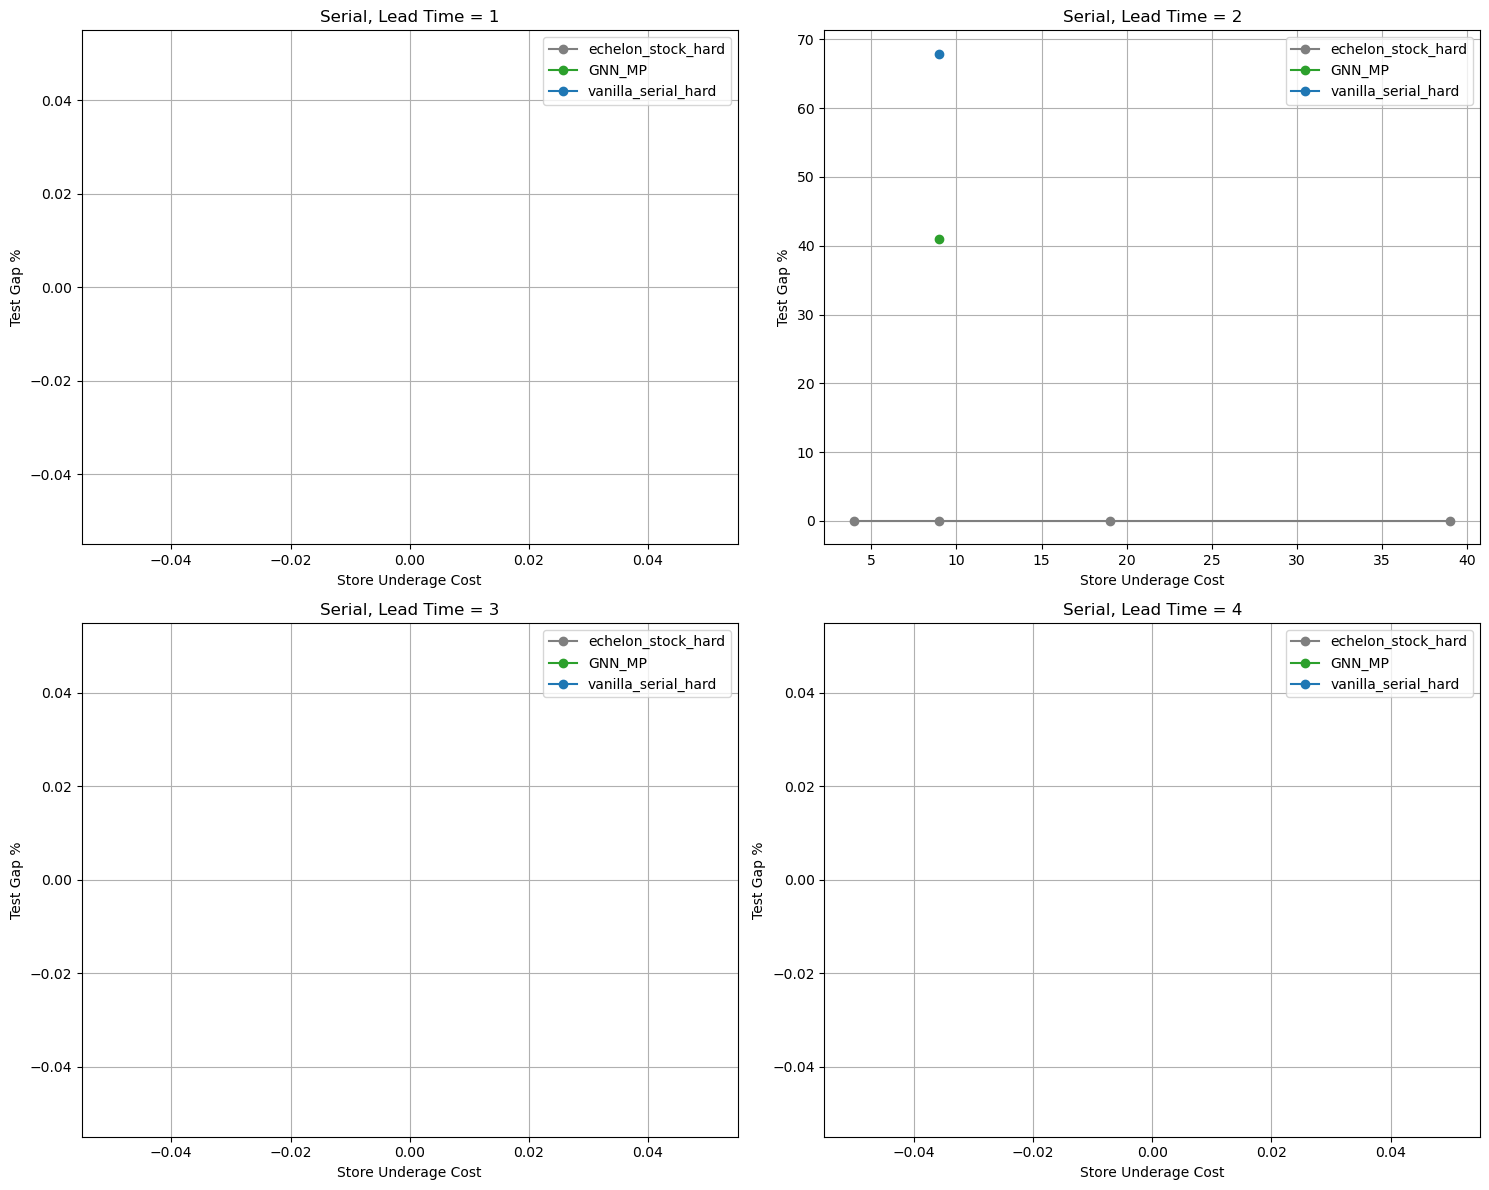

In [4]:
# Define color scheme for architecture types
color_scheme = {
    "echelon_stock_hard": "#7f7f7f",  # Purple
    "vanilla_serial_hard": "#1f77b4",  # Blue
    "GNN_MP": "#2ca02c",  # Green
}

linestyle_scheme = {
    "echelon_stock_hard": "-",  # Solid
    "vanilla_serial_hard": "-",  # Solid
    "GNN_MP": "-",  # Solid
}

testset_name = "generic_architecture_serial_hard"

# Define paths for each architecture
architectures = {
    "echelon_stock_hard": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/echelon_stock_hard',
    "vanilla_serial_hard": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_serial_hard',
    "GNN_MP": f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/GNN_MP',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

results_interpretor = rri.RayResultsinterpreter()

# Create dataframes for each architecture and parameter combination
dfs = []
params = {
    'store_lead_time': [1, 2, 3, 4],
    'store_underage_cost': [4, 9, 19, 39]
}

for arch_name, path in architectures.items():
    for lead_time in params['store_lead_time']:
        for underage_cost in params['store_underage_cost']:
            n_samples = 16
            if arch_name == "echelon_stock_hard":
                n_samples = 32768
            df = results_interpretor.make_table({1: path},
                {'store_lead_time': lead_time,
                 'store_underage_cost': underage_cost,
                 'train_n_samples': [n_samples],
                 'samples': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]},
                default_condition_setter, custom_data_filler, 
                sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
            if df.empty:
                continue
            
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['store_lead_time'] = lead_time
            df['store_underage_cost'] = underage_cost
            dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate test gap percentage
min_test_loss = df.groupby(['store_lead_time', 'store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100


print("\nDataframe Summary:")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap wide displays
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format floats to 3 decimal places

# Sort and select columns
# Calculate mean and standard deviation of test loss grouped by lead time, underage cost and architecture class
stats_df = df.groupby(['store_lead_time', 'store_underage_cost', 'Architecture Class'])['Test Loss'].agg(['mean', 'std']).reset_index()
stats_df.columns = ['store_lead_time', 'store_underage_cost', 'Architecture Class', 'Mean Test Loss', 'Test Loss Std']

# Round std to 6 decimal places
stats_df['Test Loss Std'] = stats_df['Test Loss Std'].round(6)
stats_df['Mean Test Loss'] = stats_df['Mean Test Loss'].round(6)

# Merge mean and std back into main dataframe
df_sorted = df.merge(
    stats_df, 
    on=['store_lead_time', 'store_underage_cost', 'Architecture Class'],
    how='left'
).sort_values(['store_lead_time', 'store_underage_cost'])

columns = ['store_lead_time', 'store_underage_cost', 'Architecture Class',
          'Train Loss', 'Dev Loss', 'Test Loss', 'Test Gap %', 
          'Mean Test Loss', 'Test Loss Std']
df_sorted = df_sorted.loc[df_sorted.groupby(['store_lead_time', 'store_underage_cost', 'Architecture Class'])['Dev Loss'].idxmin()]
print(df_sorted[columns].to_string(index=False))

df = df_sorted

# Create 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
axes = [ax1, ax2, ax3, ax4]

# Plot for each lead time
for idx, lead_time in enumerate(params['store_lead_time']):
    lead_time_df = df[df['store_lead_time'] == lead_time]
    
    for arch in df['Architecture Class'].unique():
        arch_data = lead_time_df[lead_time_df['Architecture Class'] == arch]
        x = arch_data['store_underage_cost'].values
        y = arch_data['Test Gap %'].values
        # Sort x and y based on x values
        sort_idx = np.argsort(x)
        x = x[sort_idx]
        y = y[sort_idx]
        
        axes[idx].plot(x, y,
                      marker='o', 
                      label=arch,
                      color=color_scheme[arch],
                      linestyle=linestyle_scheme[arch])
    
    axes[idx].set_title(f'Serial, Lead Time = {lead_time}')
    axes[idx].set_xlabel('Store Underage Cost')
    axes[idx].set_ylabel('Test Gap %')
    axes[idx].grid(True)
    axes[idx].legend()


plt.tight_layout()
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Graph and Data Setup
# ----------------------------

num_nodes = 3
num_states = 2   # binary states: 0 and 1
feature_dim = 4  # each node has a 4-dimensional feature vector

# Create random features for each node (in practice, these come from your data)
node_features = torch.randn(num_nodes, feature_dim, device=device)

# Ground-truth labels (for example, Node0=0, Node1=1, Node2=0)
true_labels = torch.tensor([0, 1, 0], dtype=torch.long, device=device)

# Define undirected graph neighbors for a chain:
# Node 0: neighbor [1]; Node 1: neighbors [0, 2]; Node 2: neighbor [1]
neighbors = {
    0: [1],
    1: [0, 2],
    2: [1]
}

# List of directed edges: for each undirected edge, we include both directions.
directed_edges = [(0, 1), (1, 0), (1, 2), (2, 1)]

# ----------------------------
# Define Learnable Potentials
# ----------------------------

# Unary potential: maps node features to a probability distribution over states.
class UnaryPotential(nn.Module):
    def __init__(self, input_dim, num_states):
        super(UnaryPotential, self).__init__()
        self.fc = nn.Linear(input_dim, num_states)
    
    def forward(self, features):
        # Produce scores then convert to probabilities
        return torch.softmax(self.fc(features), dim=-1)

# Pairwise potential: a learnable matrix for compatibility between states.
class PairwisePotential(nn.Module):
    def __init__(self, num_states):
        super(PairwisePotential, self).__init__()
        self.param = nn.Parameter(torch.randn(num_states, num_states))
    
    def forward(self):
        # Normalize each row so that for a given state of the sending node,
        # the probabilities over states for the receiving node sum to 1.
        return torch.softmax(self.param, dim=-1)

# Instantiate the learnable potentials.
unary_net = UnaryPotential(feature_dim, num_states).to(device)
pairwise_net = PairwisePotential(num_states).to(device)

# ----------------------------
# Belief Propagation Function
# ----------------------------

def belief_propagation(node_features, directed_edges, neighbors, num_iterations=3):
    # Compute unary potentials for each node: shape [num_nodes, num_states]
    phi = unary_net(node_features)  # Already normalized probabilities
    # Get pairwise potential matrix (shared for all edges)
    psi = pairwise_net()  # Shape: [num_states, num_states]
    
    # Initialize messages for each directed edge as uniform distributions.
    messages = {}
    for edge in directed_edges:
        messages[edge] = torch.ones(num_states, device=device) / num_states

    # Message passing iterations.
    for it in range(num_iterations):
        new_messages = {}
        for (i, j) in directed_edges:
            # For edge (i -> j), compute the product of incoming messages to node i from all neighbors except j.
            incoming = torch.ones(num_states, device=device)
            for k in neighbors[i]:
                if k != j:
                    incoming *= messages[(k, i)]
            # Compute new message for each possible state x_j of node j.
            m_new = torch.zeros(num_states, device=device)
            for x_j in range(num_states):
                # Sum over all states x_i for node i.
                # Vectorized: (phi[i] * incoming) is a vector over x_i.
                m_new[x_j] = torch.sum(phi[i] * incoming * psi[:, x_j])
            # Normalize the message.
            m_new = m_new / (torch.sum(m_new) + 1e-10)
            new_messages[(i, j)] = m_new
        messages = new_messages  # Update messages

    # Compute final beliefs at each node.
    beliefs = torch.zeros(num_nodes, num_states, device=device)
    for i in range(num_nodes):
        prod_in = torch.ones(num_states, device=device)
        for k in neighbors[i]:
            prod_in *= messages[(k, i)]
        b = phi[i] * prod_in
        b = b / (torch.sum(b) + 1e-10)
        beliefs[i] = b

    return beliefs

# ----------------------------
# Training Setup
# ----------------------------

# We'll use cross-entropy loss to compare the belief distribution (after taking log) with the ground-truth labels.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(list(unary_net.parameters()) + list(pairwise_net.parameters()), lr=0.01)

# ----------------------------
# Training Loop
# ----------------------------

num_epochs = 300
for epoch in range(num_epochs):
    optimizer.zero_grad()
    beliefs = belief_propagation(node_features, directed_edges, neighbors, num_iterations=3)
    # CrossEntropyLoss expects logits; here, we take log of our beliefs.
    logits = torch.log(beliefs + 1e-10)
    loss = criterion(logits, true_labels)
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ----------------------------
# Inference: Final Predicted Labels
# ----------------------------
final_beliefs = belief_propagation(node_features, directed_edges, neighbors, num_iterations=3)
predicted_labels = torch.argmax(final_beliefs, dim=1)
print("\nFinal beliefs (node marginals):")
print(final_beliefs)
print("Predicted labels:", predicted_labels.tolist())


KeyboardInterrupt: 

In [16]:
beliefs[0]

tensor([0.9900, 0.0100], device='cuda:0', grad_fn=<SelectBackward0>)